In [32]:


import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import defaultdict

from lineObjects import *

# ============= PARAMETERS TO TUNE =============
# Visualization
LINE_COLOR = (0, 255, 0)      # Green color for detected lines (BGR)
LINE_THICKNESS = 2            # Line thickness in pixels
EDGE_COLOR = (255, 255, 255)  # White color for edge
# ============================================

# Canny edge detection
CANNY_LOW_THRESHOLD = 50       # Lower = more edge pixels detected
CANNY_HIGH_THRESHOLD = 150     # Higher = only strong edges kept

# Preprocessing
BLUR_KERNEL_SIZE = 3         # Gaussian blur kernel size (must be odd)

# Hough Line Detection
HOUGH_RHO = 1                 # Distance resolution in pixels
HOUGH_THETA = np.pi / 180     # Angle resolution in radians (1 degree)
HOUGH_THRESHOLD = 10         # Minimum votes to detect a line
HOUGH_MIN_LINE_LENGTH = 50    # Minimum line length (for HoughLinesP)
HOUGH_MAX_LINE_GAP = 10       # Maximum gap between line segments (for HoughLinesP)


MIN_D_THRESH = 10 #This needs to be dynamic based on image size... we need to use hints to guess fretboard distance?



#ToDo find all candidate lines (e.g. large enough set)







In [33]:
def show_cv2_image(image, figsize=(12, 10)):
    plt.figure(figsize=figsize)  # Add this line
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

def get_canny_edges(frame):
    """
    Extract Canny edge detection from frame.

    Args:
        frame: Input BGR image

    Returns:
        edges: Binary edge image
        edges_bgr: BGR version for visualization
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (BLUR_KERNEL_SIZE, BLUR_KERNEL_SIZE), 0)

    # Canny edge detection
    edges = cv2.Canny(blurred, CANNY_LOW_THRESHOLD, CANNY_HIGH_THRESHOLD)

    # Convert edges to BGR for visualization
    edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    return edges, edges_bgr

def detect_hough_lines(edges):
    """
    Detect lines using standard Hough transform.

    Args:
        edges: Binary edge image from Canny

    Returns:
        lines: Array of lines in (rho, theta) format, or None if no lines detected
    """
    # HoughLines returns lines in (rho, theta) format
    # rho: distance from origin to the line
    # theta: angle of the line in radians
    lines = cv2.HoughLinesP(edges,HOUGH_RHO,HOUGH_THETA, HOUGH_THRESHOLD, minLineLength=HOUGH_MIN_LINE_LENGTH, maxLineGap=HOUGH_MAX_LINE_GAP)

    return lines


def filter_lines_by_angle(lines, min_angle, max_angle):
    """
    Filter lines based on their angle from the x-axis (direction ignored).

    Args:
        lines: Array of lines in (x1, y1, x2, y2) format from HoughLinesP
        min_angle: Minimum angle in radians (0 to π/2)
        max_angle: Maximum angle in radians (0 to π/2)

    Returns:
        filtered_lines: Array of lines within the specified angle range, or None if no lines pass

    Note:
        - Angle is measured from the positive x-axis (0 = horizontal, π/2 = vertical)
        - Direction is ignored: both directions of a line are treated as the same angle
        - Use 0 to π/2 radian range regardless of line direction
    """
    if lines is None:
        return None

    filtered = []

    for line in lines:
        x1, y1, x2, y2 = line[0]

        # Calculate angle from x-axis using arctan2
        # arctan2(dy, dx) gives angle in radians from -π to π
        angle = np.arctan2(y2 - y1, x2 - x1)

        # Normalize to 0 to π/2 range (ignore direction)
        angle = np.abs(angle)
        if angle > np.pi / 2:
            angle = np.pi - angle

        # Check if angle is within range
        if min_angle <= angle <= max_angle:
            filtered.append(line)

    if len(filtered) == 0:
        return None

    return np.array(filtered)


def draw_hough_lines(image, lines):
    """
    Draw all detected Hough lines on the image.

    Args:
        image: BGR image to draw on
        lines: Array of lines in (x1, y1, x2, y2) format from HoughLinesP

    Returns:
        output: Image with lines drawn
    """
    output = image.copy()

    if lines is None:
        return output

    for idx, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]

        # Calculate angle for color coding
        angle_rad = np.arctan2(y2 - y1, x2 - x1)
        cos_theta = np.cos(angle_rad)
        sin_theta = np.sin(angle_rad)

        # Color code based on angle
        origin = [120, 255/2, 255/2]
        line_colour = tuple([int(origin[0]), int(origin[1] + float(cos_theta*255/2)), int(origin[2] + sin_theta*255/2)])

        # Draw the line segment
        cv2.line(output, (x1, y1), (x2, y2), line_colour, LINE_THICKNESS)

        # Draw index at the top of the line segment (smaller y value)
        if y1 <= y2:
            text_pos = (x1, y1)
        else:
            text_pos = (x2, y2)
        cv2.putText(output, str(idx), text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, line_colour, 1)

    return output



def group_lines(vertical_lines):
    line_objs = []

    index_to_neigbours_mapping = defaultdict(set)

    for line in vertical_lines:
        x1, y1, x2, y2 = line[0]
        line_objs.append(LineSegment(x1,y1,x2,y2))


    buckets = []

    def get_bucket_index(buckets, index):
        for bucket_index in range(len(buckets)):
            if index in buckets[bucket_index]:
                return bucket_index
        return -1


    for line1_index in range(len(line_objs)):
        line1 = line_objs[line1_index]

        bucket_index = get_bucket_index(buckets, line1_index)
        if get_bucket_index(buckets,line1_index) == -1:
            buckets.append({line1_index})

        for line2_index in range(line1_index+1, len(line_objs)):
            line2 = line_objs[line2_index]
            min_d = min_distance(line1,line2)
            if min_d < MIN_D_THRESH:
                buckets[bucket_index].add(line2_index)
    

    np_lines_buckets = []
    for bucket in buckets:
        np_lines = []
        for line_index in bucket:
            np_lines.append(vertical_lines[line_index])
        
        np_lines_buckets.append(np_lines)

    return np_lines_buckets

def merge_lines_in_bucket(buckets):
    lines_to_draw = []
    for bucket in buckets:
        line =bucket[0]
        lines_to_draw.append(line)
    return lines_to_draw

def find_best_candidate_set(vertical_lines_in, horizontal_lines_in):
    # Convert numpy lines to LineSegment objects
    vertical_segments = []
    for line in vertical_lines_in:
        x1, y1, x2, y2 = line[0]
        vertical_segments.append(LineSegment(x1, y1, x2, y2))

    horizontal_segments = []
    for line in horizontal_lines_in:
        x1, y1, x2, y2 = line[0]
        horizontal_segments.append(LineSegment(x1, y1, x2, y2))

    # Map each horizontal line to the vertical segments it intersects
    horizontal_index_to_v_intersection_mapping = defaultdict(set)

    for h_index, h_segment in enumerate(horizontal_segments):
        for v_index, v_segment in enumerate(vertical_segments):
            if h_segment.line.get_intersection(v_segment):
                horizontal_index_to_v_intersection_mapping[h_index].add(v_index)

    # Find the horizontal line that intersects the most vertical lines
    best_h_index = -1
    best_h_index_count = 0
    for h_index in horizontal_index_to_v_intersection_mapping:
        if len(horizontal_index_to_v_intersection_mapping[h_index]) > best_h_index_count:
            best_h_index_count = len(horizontal_index_to_v_intersection_mapping[h_index])
            best_h_index = h_index

    # Convert back to numpy lines
    result = []
    if best_h_index >= 0:
        for v_index in horizontal_index_to_v_intersection_mapping[best_h_index]:
            result.append(vertical_lines_in[v_index])

    return result

In [34]:
def show_found_fret_lines(image_path):
    image = cv2.imread(image_path)
    edges, edges_bgr = get_canny_edges(image)
    lines = detect_hough_lines(edges)
    vertical_lines = filter_lines_by_angle(lines, min_angle=np.pi/2 - np.pi/8, max_angle=np.pi/2 + np.pi/8)
    horizontal_lines = filter_lines_by_angle(lines, min_angle=-np.pi/8, max_angle=np.pi/8)
    grouped_vertical_lines = group_lines(vertical_lines)                              
    merged_grouped_vertical_lines = merge_lines_in_bucket(grouped_vertical_lines)

    best_candidate_set_v_lines = list(find_best_candidate_set(merged_grouped_vertical_lines,horizontal_lines))
    best_candidate_set_v_lines = sorted(best_candidate_set_v_lines, key=lambda line: line[0][2])

    with_vertical_lines = draw_hough_lines(edges_bgr, best_candidate_set_v_lines)
    with_all_lines = draw_hough_lines(with_vertical_lines, horizontal_lines)
    show_cv2_image(with_vertical_lines, figsize=(24, 20))


Processing: images/perspective2.png


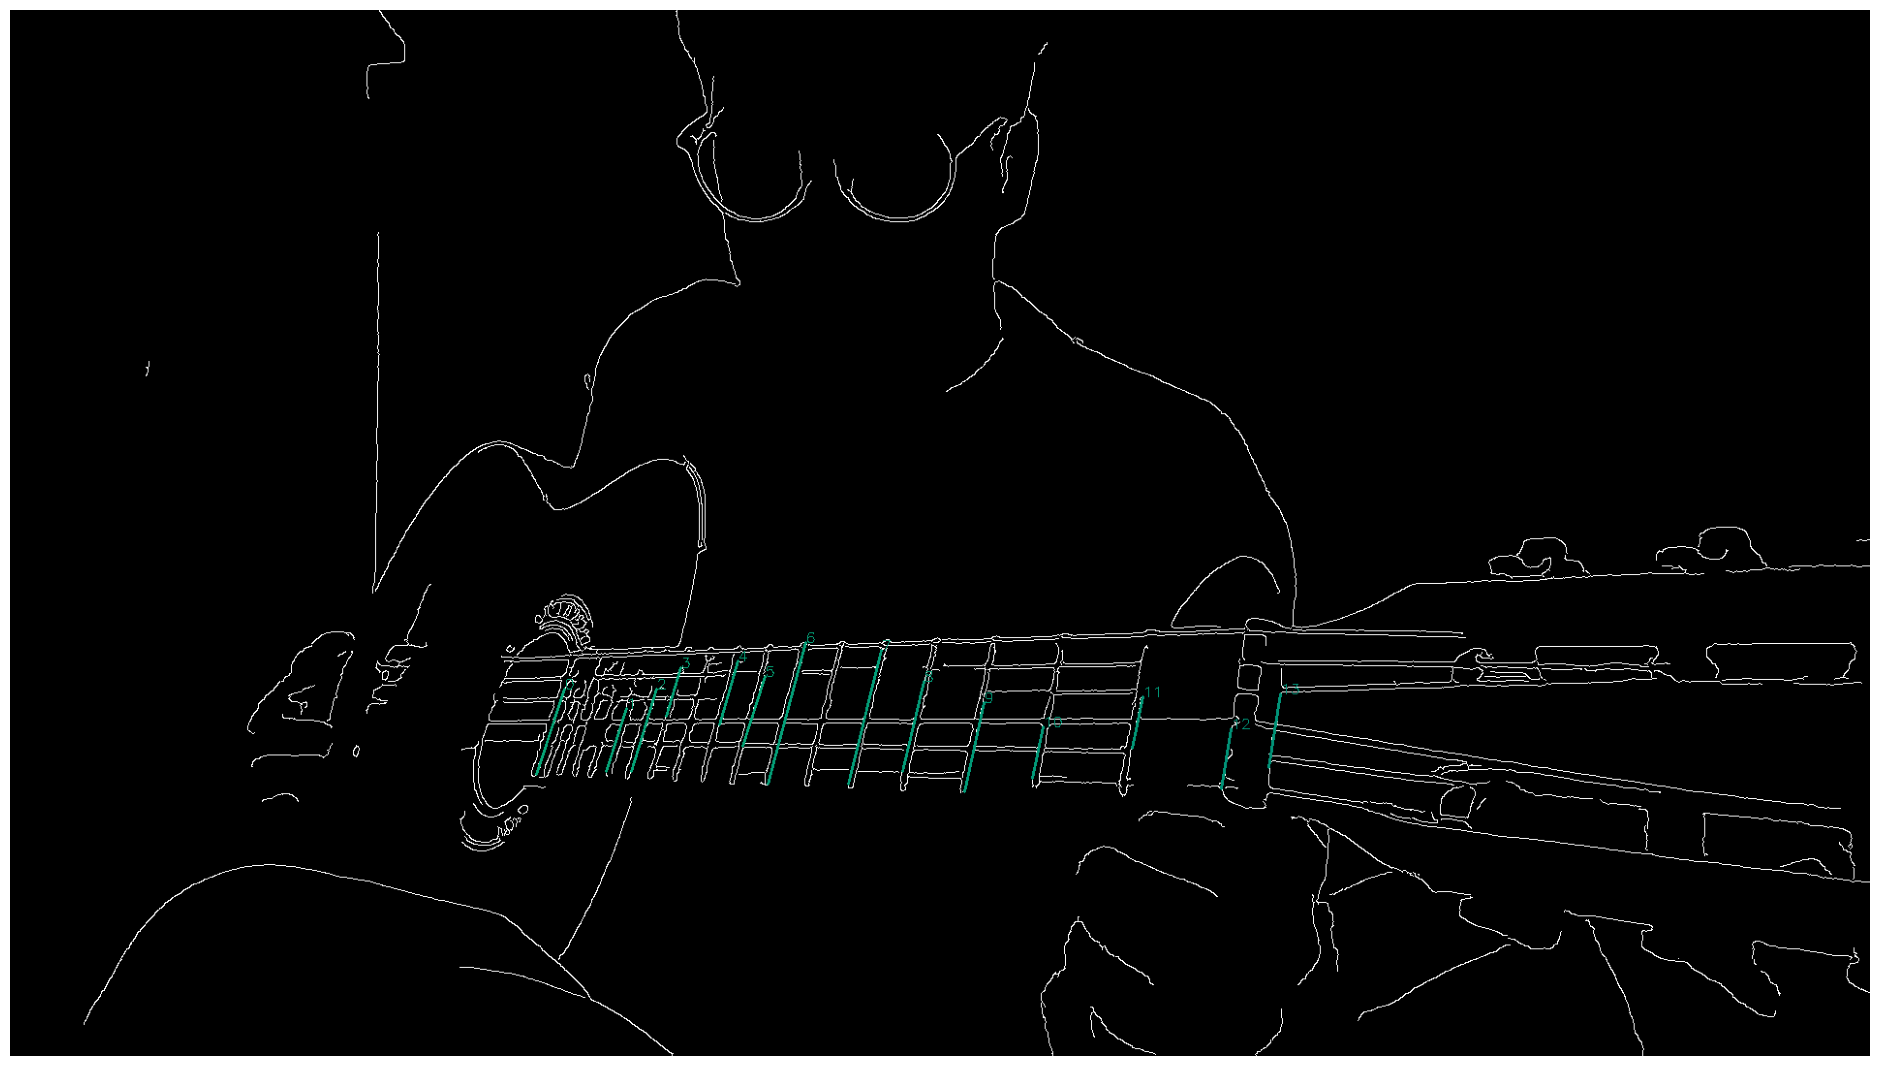

Processing: images/flat-distance.png


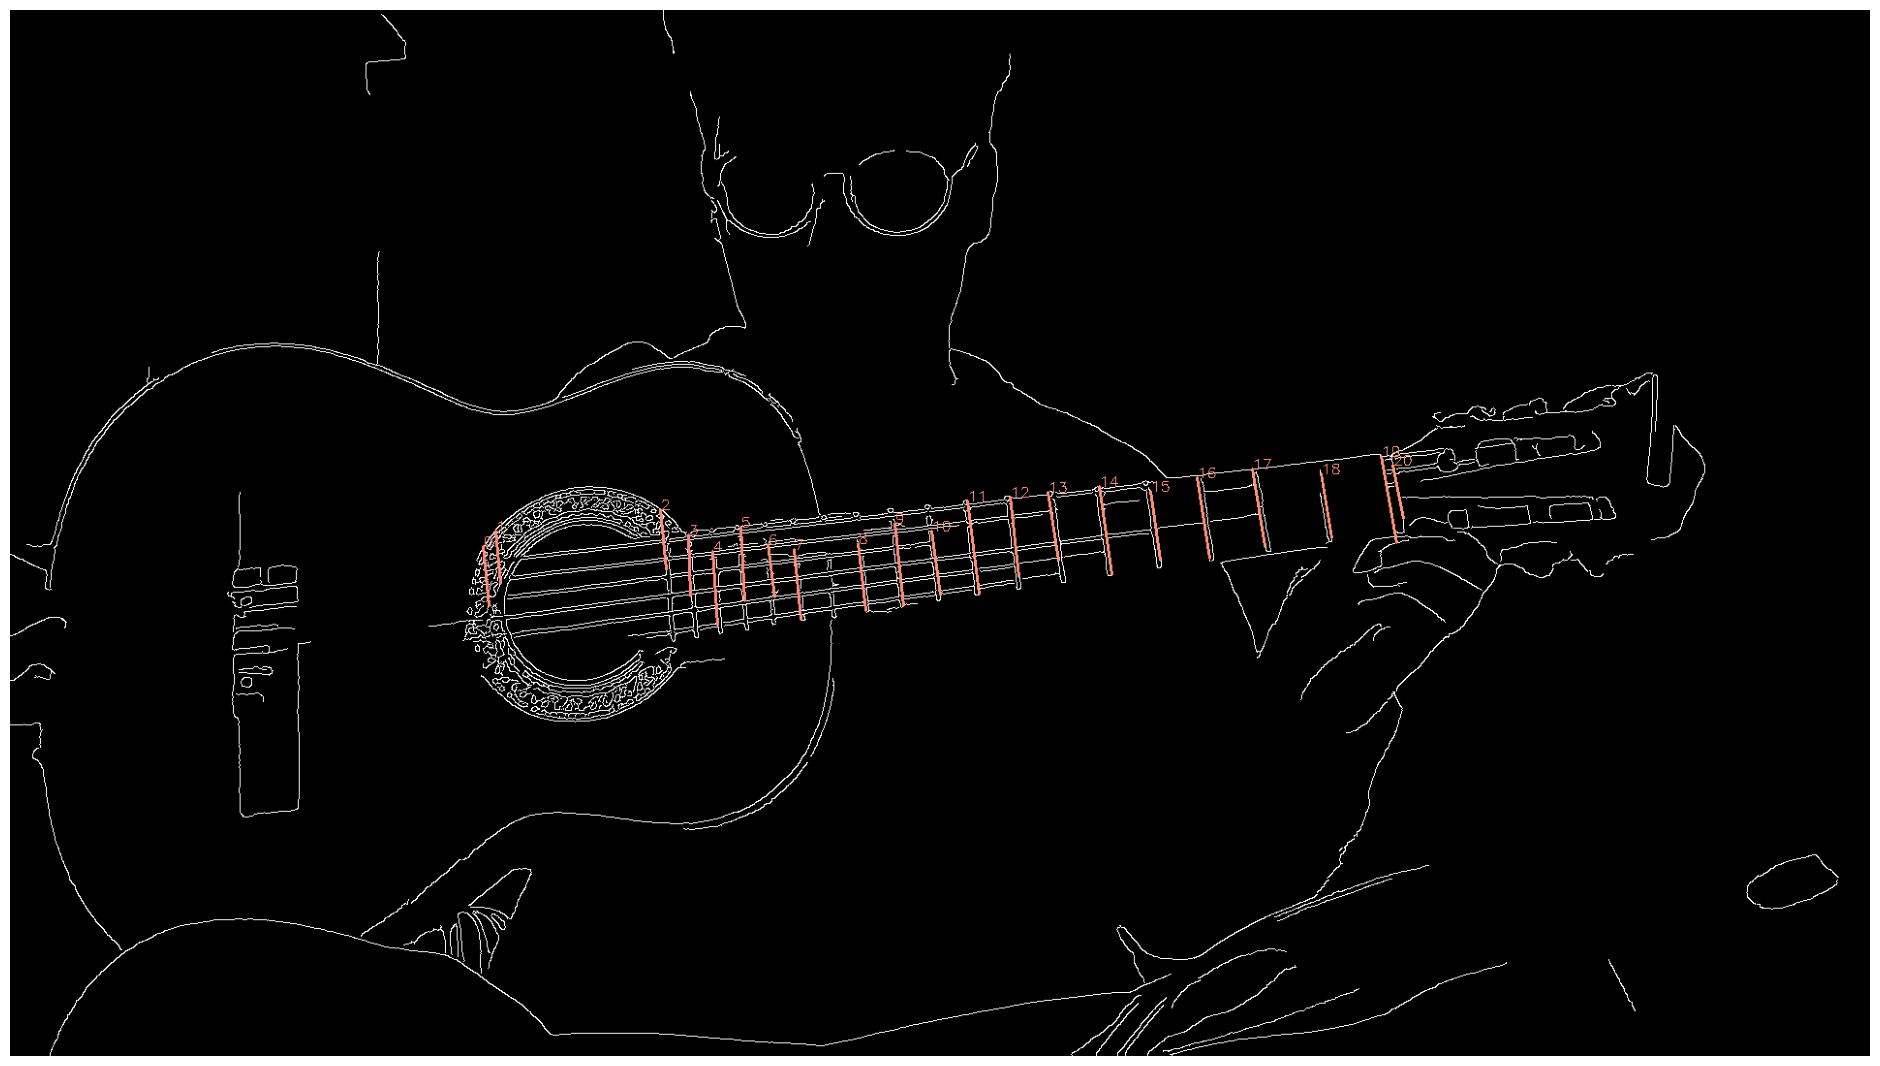

Processing: images/oclusion.png


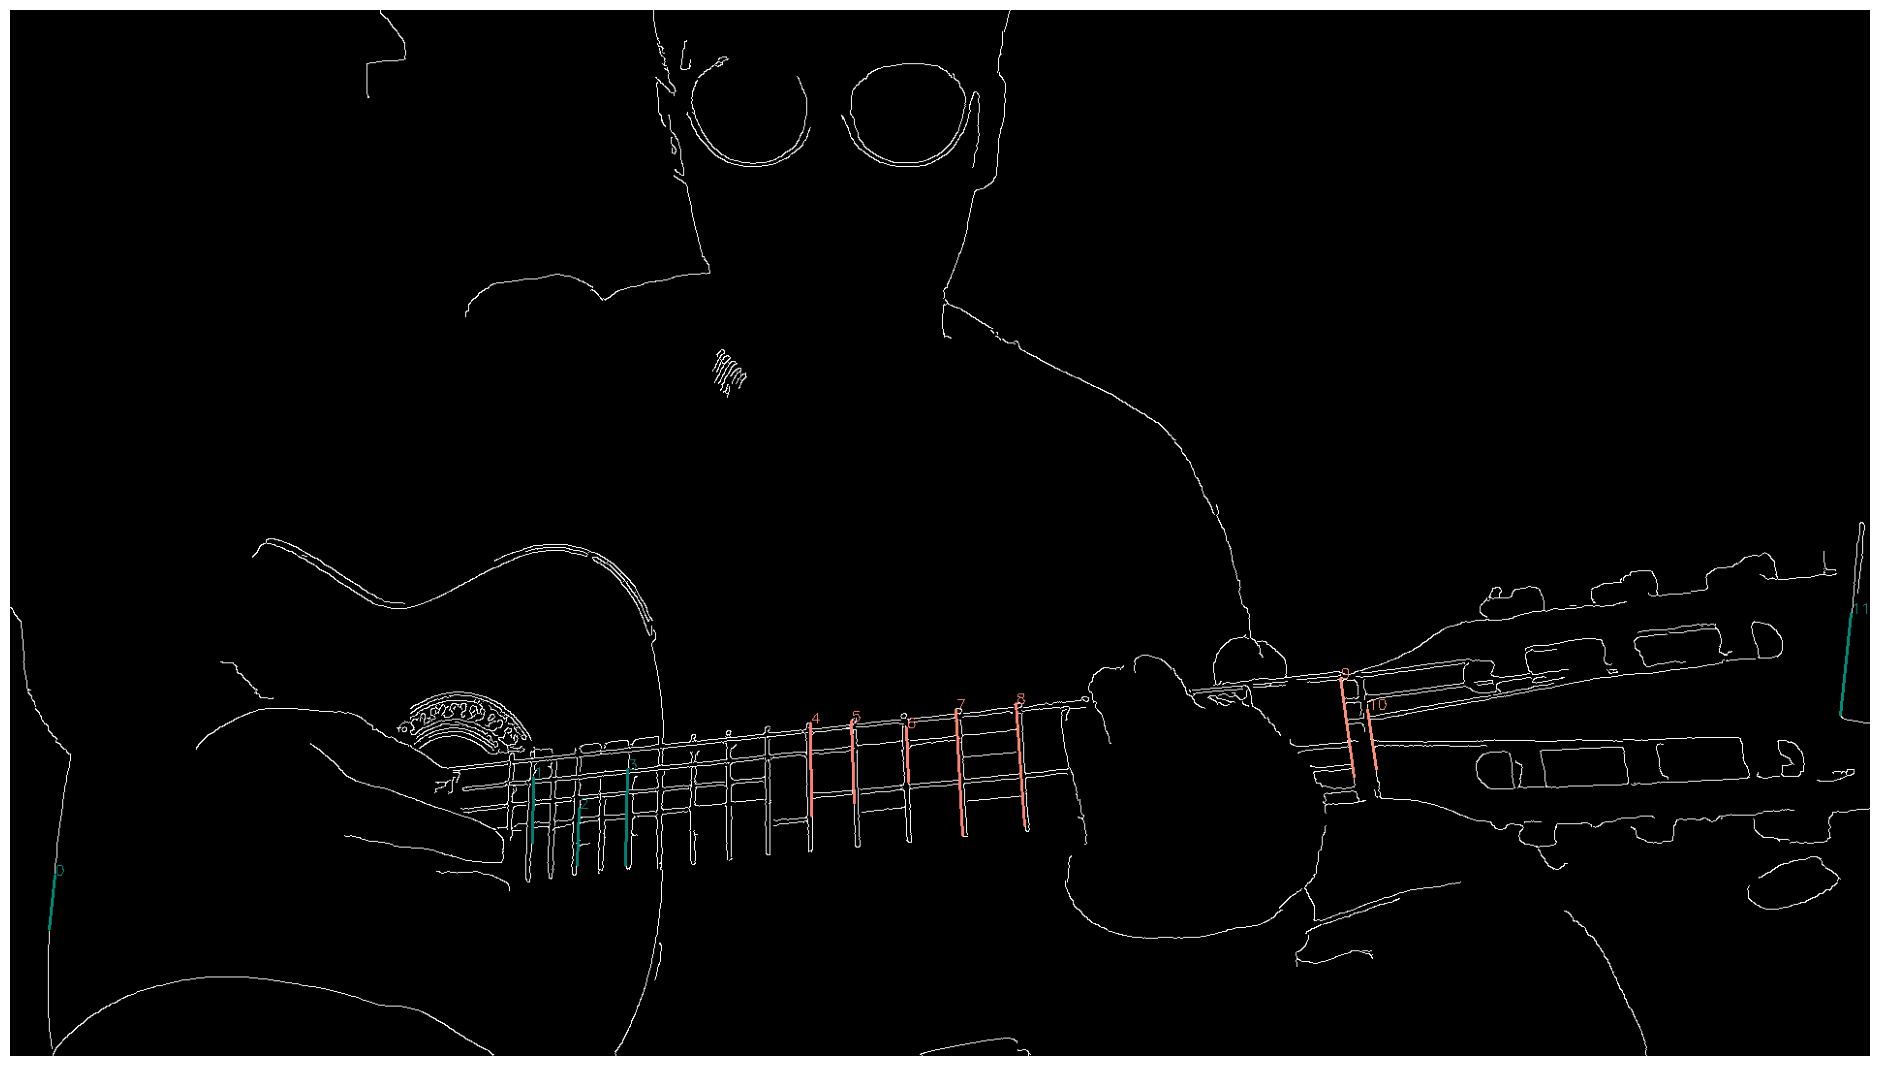

Processing: images/perspective.png


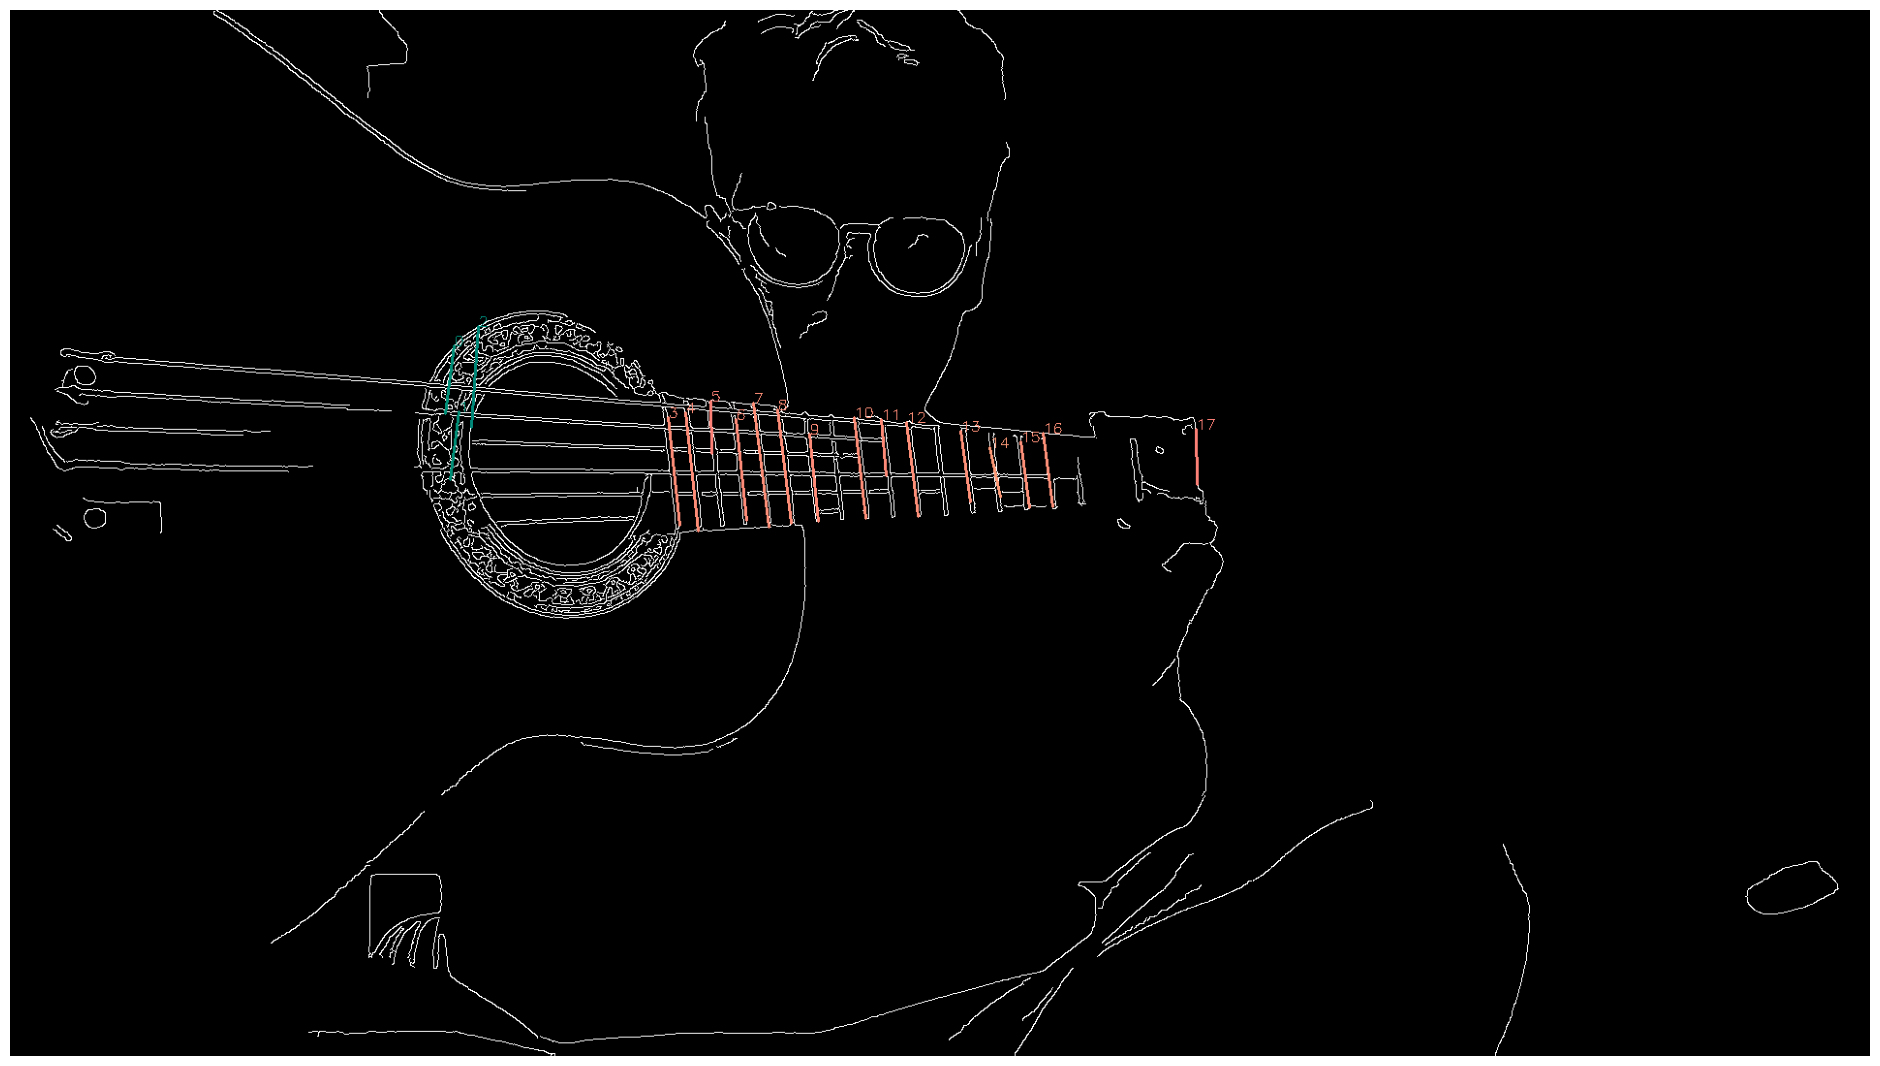

In [35]:
import glob

for image_path in glob.glob('images/*.[pj][np][g]*'):
    print(f"Processing: {image_path}")
    show_found_fret_lines(image_path)

In [ ]:
from scipy.optimize import least_squares

num_true_lines = 4
first_spacing = 1
n = np.arange(num_true_lines)


def get_true_pos(num_true_lines, first_spacing=1.0):
    scale_length = first_spacing / (1 - 2**(-1/12))
    
    n = np.arange(num_true_lines)
    
    # Calculate fret positions using the guitar fret formula
    true_pos = scale_length * (1 - 2**(-n/12))
    
    return true_pos

def mobius_transform(x, a, b, c, d):
    """Möbius transformation: f(x) = (ax + b) / (cx + d)"""
    return (a * x + b) / (c * x + d)

def inverse_mobius_transform(observed_pos, a, b, c, d):
    """
    Given observed positions and Möbius parameters a,b,c,d,
    recover the true positions.
    """
    true_pos = (d * observed_pos - b) / (a - c * observed_pos)
    return true_pos

def estimate_mobius_params(observed, num_true_lines=4):
    """
    Estimate Möbius transformation parameters from observed positions.
    
    Assumes the true positions are equally spaced starting from 0.
    Uses the constraint that Möbius transformations form a 3-parameter family (up to scaling).
    We can normalize by setting d=1.
    """
    # True positions (equally spaced, parallel when face-on)
    true_pos = get_true_pos(num_true_lines, first_spacing=first_spacing)
    
    # Define residual function
    def residuals(params):
        a, b, c = params
        d = 1.0  # Normalize
        predicted = mobius_transform(true_pos, a, b, c, d)
        return predicted - observed
    
    # Initial guess
    x0 = [1.0, 0.0, 0.0]
    
    # Solve
    result = least_squares(residuals, x0, method='lm')
    
    a, b, c = result.x
    d = 1.0
    
    return a, b, c, d, result
